In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/iamsouravbanerjee/house-rent-prediction-dataset")

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
Dataset=pd.read_csv("house-rent-prediction-dataset\House_Rent_Dataset.csv")

In [20]:
Dataset.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,month_year
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,2022-05
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,2022-05
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,2022-05
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,2022-07
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,2022-05


In [18]:
Dataset['month_year'] = Dataset['Posted On'].astype(str).str[:7]

In [21]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
 12  month_year         4746 non-null   object
dtypes: int64(4), object(9)
memory usage: 482.1+ KB


In [80]:
Dataset_final=Dataset.drop(["Posted On","Point of Contact","Floor", 'Area Locality'] ,axis=1)

In [81]:
Dataset_final.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,month_year
0,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,2022-05
1,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,2022-05
2,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,2022-05
3,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,2022-07
4,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,2022-05


In [82]:
Dataset_final.describe()

,BHK,Rent,Size,Bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


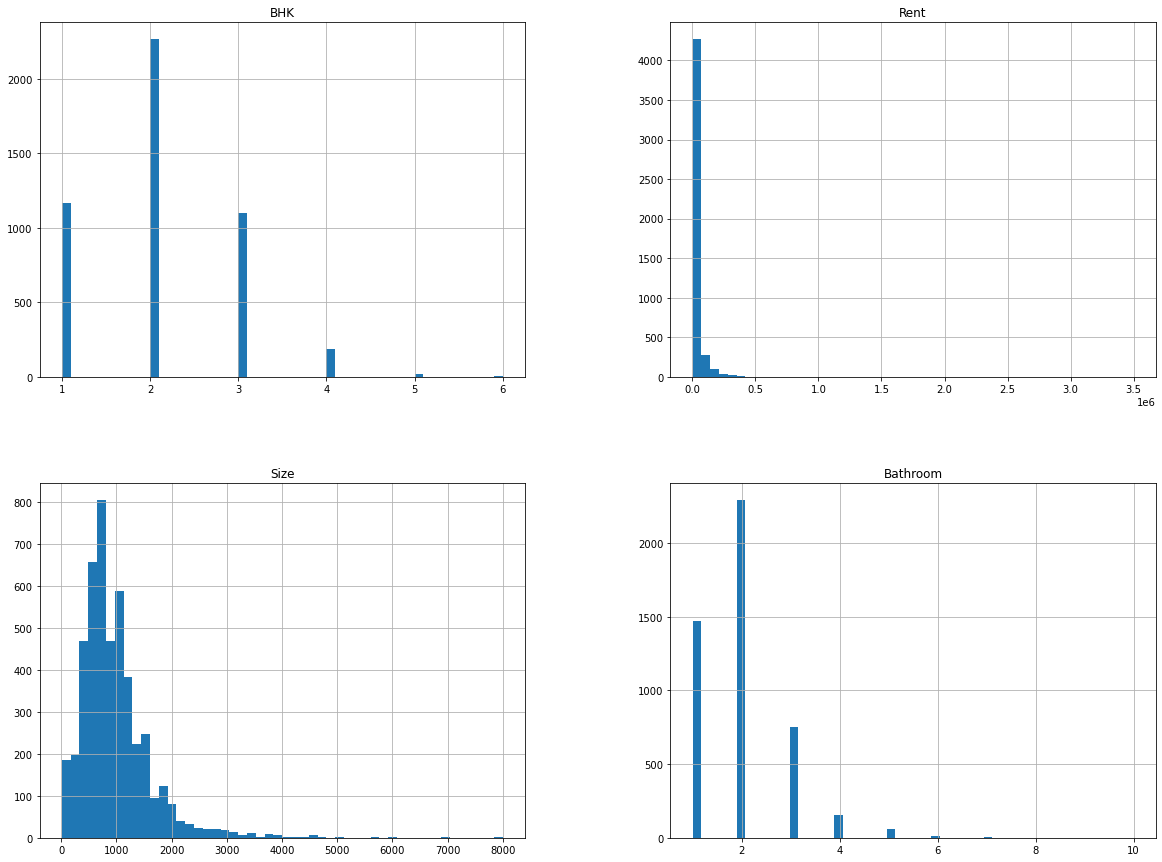

In [26]:
%matplotlib inline 
Dataset_final.hist(bins=50, figsize=(20,15))
plt.show()

In [83]:
Dataset_final.isnull().sum()


BHK                  0
Rent                 0
Size                 0
Area Type            0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
month_year           0
dtype: int64

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Size', ylabel='Rent'>

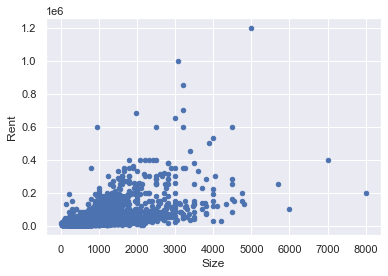

In [97]:
Dataset_final.plot(kind="scatter", x="Size", y="Rent")

In [94]:
Dataset_final["Rent"].max()

1200000

In [92]:
max_index=Dataset_final[Dataset_final["Rent"]==Dataset_final["Rent"].max()].index

In [93]:
Dataset_final=Dataset_final.drop(max_index, axis=0)

In [95]:
corr_matrix=Dataset_final.corr()
corr_matrix["Rent"].sort_values(ascending=False)

Rent        1.000000
Bathroom    0.562577
Size        0.511398
BHK         0.469925
Name: Rent, dtype: float64

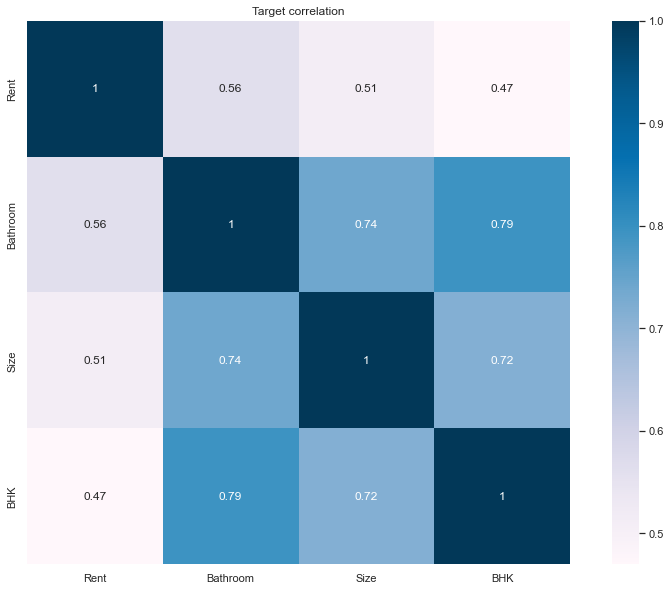

In [96]:
import seaborn as sns
corr_data = Dataset_final[Dataset_final.keys()]
cmap = plt.cm.PuBu
cols = corr_data.corr().nlargest(len(Dataset_final.keys()),'Rent')['Rent'].index
cm = np.corrcoef(Dataset_final[cols].values.T)
f,ax = plt.subplots(figsize=(15,10))
plt.title('Target correlation')
sns.heatmap(cm,vmax=1,annot=True,square=True,xticklabels=cols.values,yticklabels=cols.values,cmap=cmap)
plt.show()

In [66]:
Dataset_final.columns

Index(['BHK', 'Rent', 'Size', 'Area Type', 'Area Locality', 'City',
       'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'month_year'],
      dtype='object')

In [98]:
Dataset_final['month_year'].value_counts()

2022-06    1858
2022-05    1681
2022-07     978
2022-04     228
Name: month_year, dtype: int64

In [99]:
from sklearn.model_selection import train_test_split
X=Dataset_final.drop("Rent", axis=1)
y=Dataset_final["Rent"].copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(f"Training {X_train.shape}, Test {X_test.shape}")

Training (3796, 8), Test (949, 8)


In [100]:
num_attr=["BHK","Size","Bathroom"]
cat_attr=[ 'Area Type', 'City',
       'Furnishing Status', 'Tenant Preferred', 'month_year']

In [101]:
full_pipe=ColumnTransformer([
    ('num', StandardScaler(), num_attr),
    ('cat', OneHotEncoder(sparse=False, categories='auto'), cat_attr)],
        remainder='passthrough'
)

X_train_prepared=full_pipe.fit_transform(X_train)

In [102]:
pd.DataFrame(X_train_prepared).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.105415,-0.263858,0.041788,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-1.303485,-0.731714,-1.091263,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,-0.105415,0.359950,0.041788,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,2.290725,1.763519,2.307890,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-1.303485,-1.043619,-1.091263,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [104]:
models = {
    'ridge' : Ridge(),
    'xgboost' : XGBRegressor(),
    'catboost' : CatBoostRegressor(verbose=0),
    'lightgbm' : LGBMRegressor(),
    'gradient boosting' : GradientBoostingRegressor(),
    'lasso' : Lasso(),
    'random forest' : RandomForestRegressor(),
    'bayesian ridge' : BayesianRidge(),
    'support vector': SVR(),
    'knn' : KNeighborsRegressor(n_neighbors = 4)
}

In [123]:
results = {}
for name, model in models.items():
    model.fit(X_train_prepared, y_train)
    scores = -cross_val_score(model, X_train_prepared, y_train, scoring = 'neg_mean_squared_error', cv=10)
    results[name] = round(np.mean(np.sqrt(scores)),3)

    print(f'{name} trained')
    print("Data shows that the mean is %0.2f and the standard deviation is %0.2f" % (np.sqrt(scores).mean(), np.sqrt(scores).std()))

ridge trained
Data shows that the mean is 40073.92 and the standard deviation is 8685.47
xgboost trained
Data shows that the mean is 32857.14 and the standard deviation is 7928.40
catboost trained
Data shows that the mean is 31568.04 and the standard deviation is 8261.89
lightgbm trained
Data shows that the mean is 29809.53 and the standard deviation is 6700.96
gradient boosting trained
Data shows that the mean is 30823.64 and the standard deviation is 6487.46


C:\Users\Setar\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178502251896.65625, tolerance: 1297942767.2150574
  model = cd_fast.enet_coordinate_descent(
C:\Users\Setar\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165950108672.55078, tolerance: 1218804077.9404843
  model = cd_fast.enet_coordinate_descent(
C:\Users\Setar\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166776806336.93945, tolerance: 1177186325.1007288
  model = cd_fast.enet_coordinate_descent(
C:\Users\Setar\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Convergence

lasso trained
Data shows that the mean is 40075.39 and the standard deviation is 8681.61
random forest trained
Data shows that the mean is 31334.95 and the standard deviation is 6265.66
bayesian ridge trained
Data shows that the mean is 40066.81 and the standard deviation is 8710.08
support vector trained
Data shows that the mean is 60398.21 and the standard deviation is 9707.28
knn trained
Data shows that the mean is 35987.90 and the standard deviation is 8069.89


In [124]:
results

{'ridge': 40073.917,
 'xgboost': 32857.139,
 'catboost': 31568.038,
 'lightgbm': 29809.532,
 'gradient boosting': 30823.635,
 'lasso': 40075.387,
 'random forest': 31334.945,
 'bayesian ridge': 40066.806,
 'support vector': 60398.215,
 'knn': 35987.905}

In [125]:
results_df = pd.DataFrame(results, index=range(0,1)).T.rename(columns={0: 'RMSE'}).sort_values('RMSE', ascending=False)
results_df

,RMSE
support vector,60398.215
lasso,40075.387
ridge,40073.917
bayesian ridge,40066.806
knn,35987.905
xgboost,32857.139
catboost,31568.038
random forest,31334.945
gradient boosting,30823.635
lightgbm,29809.532


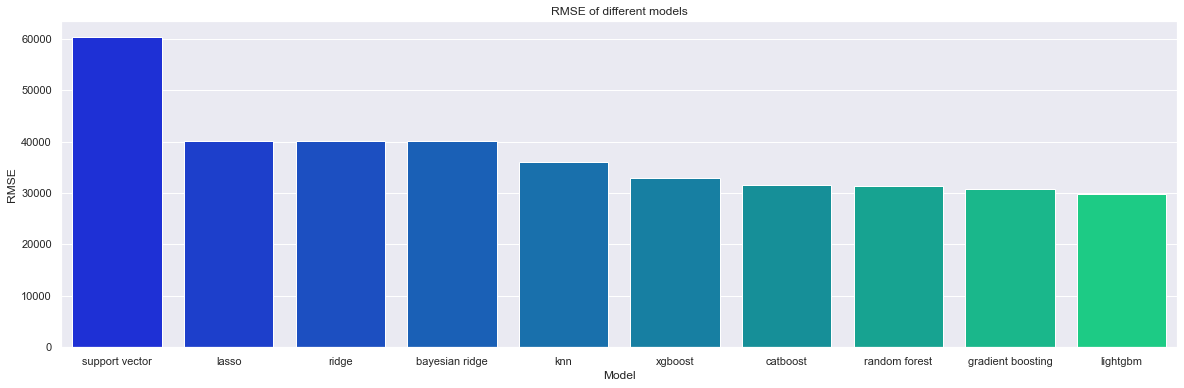

In [126]:
plt.figure(figsize = (20, 6))
sns.barplot(x= results_df.index, y = results_df['RMSE'], palette = 'winter')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE of different models');

In [173]:
RSME_Test={}

for name , model in models.items():
    Res=np.sqrt(mean_squared_error(y_test, model.predict(full_pipe.transform(X_test))))
    RSME_Test[name]=round(Res,3)

In [174]:
RSME_Test

{'ridge': 45623.218,
 'xgboost': 39770.43,
 'catboost': 35917.144,
 'lightgbm': 35797.688,
 'gradient boosting': 34894.576,
 'lasso': 45625.978,
 'random forest': 36326.342,
 'bayesian ridge': 45636.459,
 'support vector': 67157.15,
 'knn': 46111.809}

In [176]:
test_df = pd.DataFrame(RSME_Test, index=range(0,1)).T.rename(columns={0: 'RMSE'}).sort_values('RMSE', ascending=False)


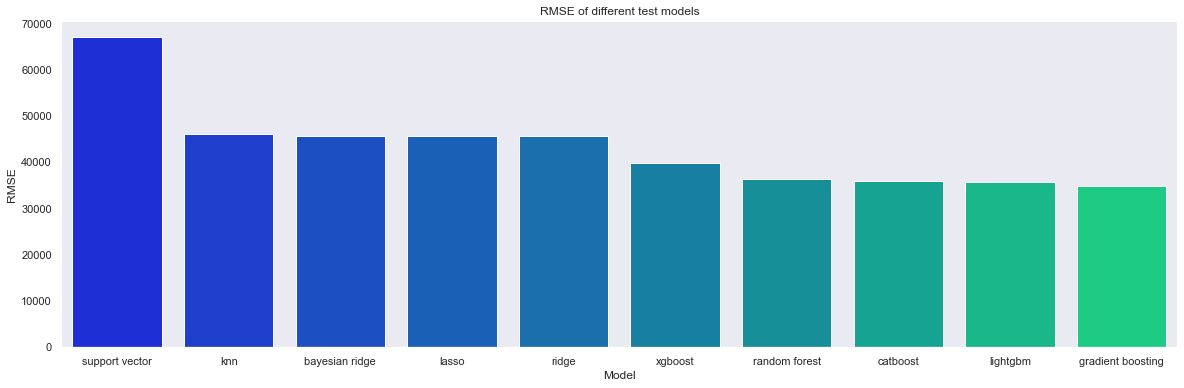

In [177]:
plt.figure(figsize = (20, 6))
sns.barplot(x= test_df.index, y = test_df['RMSE'], palette = 'winter')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE of different test models');

In [178]:
# Aggredating the predictions from best 5 models

y_pred_Final=  (
    .2* models['gradient boosting'].predict(full_pipe.transform(X_test)) +
    .2* models['lightgbm'].predict(full_pipe.transform(X_test)) +
    .2* models['random forest'].predict(full_pipe.transform(X_test)) +
    .2* models['catboost'].predict(full_pipe.transform(X_test)) +
    .2* models['xgboost'].predict(full_pipe.transform(X_test)) 
)
    

In [179]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_Final))}')
print(f'R-square: {r2_score(y_test, y_pred_Final)}')

RMSE: 35676.67191051018
R-square: 0.6948948949472173


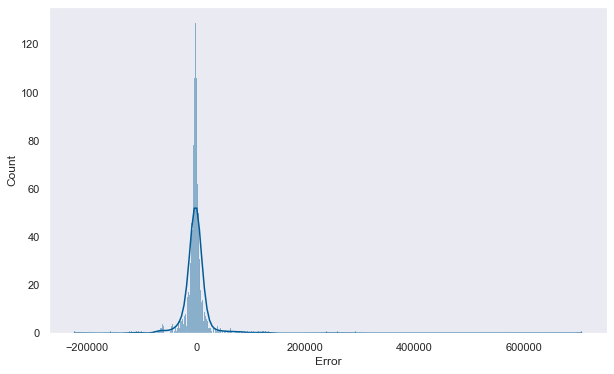

In [180]:
# Distribution of error
plt.figure(figsize = (10, 6))
sns.histplot(y_test - y_pred_Final , color = '#005b96', kde= True)
plt.xlabel('Error');

##### The residuals look almost normal with the mean of zero, reflecting the fact that the model is adequate and there is no pattern left in the residuals.